# Modelos de Predicción

# Librerias

In [1]:
# operaciones datos y numéricas
import numpy as np
import pandas as pd
import math

# sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
## regresiones y clasificaciones
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,IsolationForest,GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR,SVC
from sklearn.neighbors import KNeighborsRegressor
## herramientas sklearn
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score,accuracy_score, f1_score, roc_auc_score,classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV,cross_val_predict

# graficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

# estadisticas
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy.stats import ks_2samp
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

# Para guardar modelos
import joblib

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

# Carga de Datos

In [251]:
#df_capstone=pd.read_excel('ArchivosExcel/dataset_regresion.xlsx')
df_capstone=pd.read_excel('ArchivosExcel/df_capstone.xlsx')
#df_capstone_sfs=pd.read_excel('/content/drive/MyDrive/Magister/capstone/datos/df_capstone_sfs.xlsx')
df_capstone=df_capstone.drop(columns=['Recuperacion_Turno','Fecha','Turno'])#,'Alim CuI'])
df_regresion = df_capstone.copy()
df_regresion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Alim_CuT           600 non-null    float64
 1   Alim_CuS           600 non-null    float64
 2   Alim CuI           600 non-null    float64
 3   Ag                 600 non-null    float64
 4   Pb                 600 non-null    float64
 5   Fe                 600 non-null    float64
 6   P80_Alim_Ro300     600 non-null    float64
 7   pH_Ro300           600 non-null    float64
 8   Tratamiento_Turno  600 non-null    float64
 9   Sol_Cit            600 non-null    float64
 10  Aire_Celdas        600 non-null    float64
 11  Nivel_Celdas       600 non-null    float64
dtypes: float64(12)
memory usage: 56.4 KB


# Modelos de Predicción

## preparación de los datos

### datos para regresiones

In [5]:
X_reg = df_regresion.drop('Recuperacion_Turno', axis=1)
X_reg['cumple']=np.where(df_regresion['Recuperacion_Turno']>=86,1,0)
## Etiquetas / clases
y_reg = df_regresion['Recuperacion_Turno']
train_dataset_reg, test_dataset_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42,stratify=X_reg['cumple'])
## train test split
X_train_reg = train_dataset_reg.drop(columns=['cumple'], axis=1)
X_test_reg = test_dataset_reg.drop(columns=['cumple'], axis=1)

### comparar distribución de recuperacion entre train y test

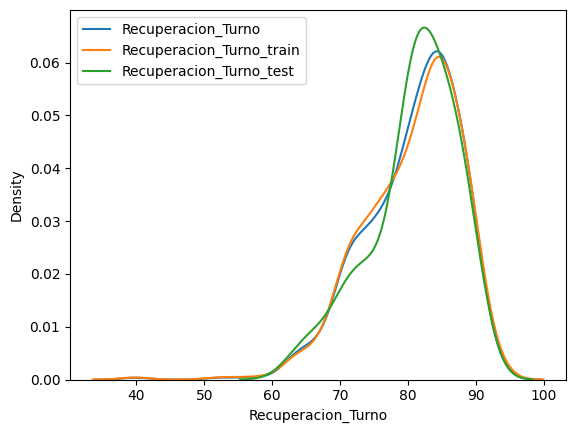

In [7]:
# comparar distribucion de recuperacion entre train y test
sns.kdeplot(y_reg)
sns.kdeplot(y_train_reg)
sns.kdeplot(y_test_reg)
plt.legend(['Recuperacion_Turno', 'Recuperacion_Turno_train', 'Recuperacion_Turno_test'])
plt.show()

## Experimento con distintos modelos supervisados de predicción

### Experimento inicial sin Gridsearch

In [11]:
# Lista de modelos a evaluar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Support Vector Regression': SVR(),
    'Extra Trees': ExtraTreesRegressor(),
}

# Diccionario para guardar los resultados
results = []

# Evaluación de cada modelo
for name, model in models.items():
    # Predicción cruzada para obtener predicciones y calcular métricas
    y_pred = cross_val_predict(model, X_train_reg, y_train_reg, cv=5)

    # Calcular métricas
    r2 = r2_score(y_train_reg, y_pred)
    mse = mean_squared_error(y_train_reg, y_pred)
    mae = mean_absolute_error(y_train_reg, y_pred)
    rmse = np.sqrt(mse)

    # Calcular el R^2 ajustado en el conjunto de entrenamiento
    n = X_train_reg.shape[0]  # Número de muestras
    p = X_train_reg.shape[1]  # Número de predictores
    r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)


    # Guardar resultados en una lista de diccionarios
    results.append({
        'Model': name,
        'R2': r2,
        'R2_Adj': r2_adjusted,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    })

# Convertir los resultados en DataFrame para mejor visualización
results_exp = pd.DataFrame(results)


# Mostrar los resultados ordenados por R2
#display(results_exp.query("R2_Adj>=0.2").sort_values(by='R2_Adj', ascending=False))
display(results_exp.sort_values(by='R2_Adj', ascending=False))

,Model,R2,R2_Adj,MSE,MAE,RMSE
0,Linear Regression,0.374964,0.360273,31.845056,4.259030,5.643142
1,Ridge Regression,0.373401,0.358673,31.924708,4.268397,5.650195
7,Extra Trees,0.344393,0.328984,33.402597,4.300602,5.779498
3,Random Forest,0.319882,0.303896,34.651443,4.316554,5.886548
4,Gradient Boosting,0.280959,0.264059,36.634520,4.456634,6.052646
2,Lasso Regression,0.264702,0.247420,37.462786,4.656631,6.120685
5,AdaBoost,0.227719,0.209567,39.347074,4.778527,6.272725
6,Support Vector Regression,0.063431,0.041418,47.717372,5.310597,6.907776


In [15]:
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
}

# Espacios de hiperparámetros para cada modelo
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 250,500],
        'max_depth': [1,10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        #'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_weight_fraction_leaf': [0.2, 0.4],
        },
    'Extra Trees': {
        'n_estimators': [50,100, 250,500],
        'max_depth': [1, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        #'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        'min_weight_fraction_leaf': [0.2, 0.4],
        'max_features': [None, 'sqrt', 'log2'],
        },
    'Linear Regression': {
        'fit_intercept': [True, False],
        },
    'Ridge': {
        'alpha': [0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'tol': [1e-3, 1e-4, 1e-5],
        },
    }

# Diccionario para guardar los mejores modelos y sus hiperparámetros
best_models = {}

for name, model in models.items():
    print(f"mejores hiperparámetros para {name}...")

    # Usa GridSearchCV o RandomizedSearchCV con el espacio de hiperparámetros
    search = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=-1)

    # Ajusta el modelo
    search.fit(X_train_reg, y_train_reg)

    # Guarda el mejor modelo y los mejores hiperparámetros
    best_models[name] = {
        'best_estimator': search.best_estimator_,
        'best_params': search.best_params_,
        'best_score': search.best_score_  # Cambia a positivo si es más fácil de interpretar
    }

    print(f"Mejores hiperparámetros para {name}: {search.best_params_}")
    print(f"Mejor puntaje (R2): {search.best_score_}\n")

mejores hiperparámetros para Linear Regression...
Mejores hiperparámetros para Linear Regression: {'fit_intercept': True}
Mejor puntaje (R2): 0.37409580268355525

mejores hiperparámetros para Ridge...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.58713e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.07374e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.90731e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.75848e-17): result may not be acc

Mejores hiperparámetros para Ridge: {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto', 'tol': 0.001}
Mejor puntaje (R2): 0.37472757646473936

mejores hiperparámetros para Random Forest...
Mejores hiperparámetros para Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.2, 'n_estimators': 50}
Mejor puntaje (R2): 0.19491513104888186

mejores hiperparámetros para Extra Trees...
Mejores hiperparámetros para Extra Trees: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.2, 'n_estimators': 50}
Mejor puntaje (R2): 0.14145754319113274



In [16]:
# Mostrar los mejores modelos y sus hiperparámetros
for name, details in best_models.items():
    print(f"{name}:")
    print(f"  Mejores hiperparámetros: {details['best_params']}")
    print(f"  Mejor puntaje (R2): {details['best_score']}\n")

Linear Regression:
  Mejores hiperparámetros: {'fit_intercept': True}
  Mejor puntaje (R2): 0.37409580268355525

Ridge:
  Mejores hiperparámetros: {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto', 'tol': 0.001}
  Mejor puntaje (R2): 0.37472757646473936

Random Forest:
  Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.2, 'n_estimators': 50}
  Mejor puntaje (R2): 0.19491513104888186

Extra Trees:
  Mejores hiperparámetros: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.2, 'n_estimators': 50}
  Mejor puntaje (R2): 0.14145754319113274



In [28]:
modelo_LR_Reg=LinearRegression(fit_intercept=True).fit(X_train_reg, y_train_reg)
modelo_RI_Reg=Ridge(alpha=0.1,fit_intercept=True,solver='auto',tol=0.001, random_state=42).fit(X_train_reg, y_train_reg)
modelo_LA_Reg=Lasso(alpha=0.1, fit_intercept=True,max_iter=100, random_state=42).fit(X_train_reg, y_train_reg)
modelo_RF_Reg=RandomForestRegressor(max_depth=10,min_samples_split=5, n_estimators=100, random_state=42).fit(X_train_reg, y_train_reg)
modelo_ET_REG=ExtraTreesRegressor(max_depth=7,n_estimators=100,random_state=42).fit(X_train_reg, y_train_reg)

In [29]:
modelos=[modelo_LR_Reg,modelo_RI_Reg,modelo_LA_Reg,modelo_RF_Reg,modelo_ET_REG]
modelos_nombres=['LinearRegression','Ridge','Lasso','RandomForestRegressor','ExtraTreesRegressor']

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mae_score_test=[]
mape_score_test=[]
mae_score_train=[]
mape_score_train=[]
modelo_name=[]
mse_score_train=[]
mse_score_test=[]
rmse_score_train=[]
rmse_score_test=[]
r2_ajust=[]
for modelo in modelos:
    r2ajust=1 - (1 - modelo.score(X_train_reg, y_train_reg))*(X_train_reg.shape[0]-1)/(X_train_reg.shape[0]-X_train_reg.shape[1]-1)
    mae_test = mean_absolute_error(y_test_reg, modelo.predict(X_test_reg))
    mape_test=mean_absolute_percentage_error(y_test_reg, modelo.predict(X_test_reg))*100
    mae_train = mean_absolute_error(y_train_reg, modelo.predict(X_train_reg))
    mape_train=mean_absolute_percentage_error(y_train_reg, modelo.predict(X_train_reg))*100
    mse_train = mean_squared_error(y_train_reg, modelo.predict(X_train_reg))
    mse_test = mean_squared_error(y_test_reg, modelo.predict(X_test_reg))
    rmse_train=np.sqrt(mse_train)
    rmse_test=np.sqrt(mse_test)

    mae_score_test.append(mae_test)
    mape_score_test.append(mape_test)
    mae_score_train.append(mae_train)
    mape_score_train.append(mape_train)
    modelo_name.append(modelos_nombres[modelos.index(modelo)])
    r2_ajust.append(r2ajust)
    mse_score_train.append(mse_train)
    rmse_score_train.append(rmse_train)
    mse_score_test.append(mse_test)
    rmse_score_test.append(rmse_test)
    #print("Testeo")
    #print(accuracy_score(y_test_clas, pred_train))
    #print(classification_report(y_test_clas,pred_test))

df_mse=pd.DataFrame({'modelo':modelo_name,'R2 ajustado':r2_ajust,'mae_test':mae_score_test,'mape_test':mape_score_test,'mae_train':mae_score_train,'mape_train':mape_score_train,'mse_train':mse_score_train,'rmse_train':rmse_score_train,'mse_test':mse_score_test,'rmse_test':rmse_score_test})
df_mse

,modelo,R2 ajustado,mae_test,mape_test,mae_train,mape_train,mse_train,rmse_train,mse_test,rmse_test
0,LinearRegression,0.393747,3.983480,5.064647,4.154621,5.404024,30.178771,5.493521,28.146818,5.305357
1,Ridge,0.393693,3.984846,5.066033,4.153895,5.404029,30.181414,5.493761,28.134134,5.304162
2,Lasso,0.360900,4.133144,5.252332,4.255368,5.549528,31.813839,5.640376,29.820067,5.460775
3,RandomForestRegressor,0.848029,3.976109,5.053777,1.990972,2.602427,7.565007,2.750456,26.935047,5.189899
4,ExtraTreesRegressor,0.738965,3.795771,4.850262,2.781399,3.571572,12.994079,3.604730,25.986674,5.097713


## Prueba de Hiperparametros y calibración sobreajuste

### Random Forest

In [45]:
modelo_RF_Reg_v2=RandomForestRegressor(max_depth=10,min_samples_split=9, n_estimators=500, random_state=42).fit(X_train_reg, y_train_reg)
modelo_RF_Reg_v2_1=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=2, n_estimators=500, random_state=42).fit(X_train_reg, y_train_reg) # 'min_weight_fraction_leaf': 0.2,
modelo_RF_Reg_v2_2=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=3, n_estimators=500, random_state=42).fit(X_train_reg, y_train_reg) #'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.2,
modelo_RF_Reg_v2_3=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=4, n_estimators=500, random_state=42).fit(X_train_reg, y_train_reg) #'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.2,
modelo_RF_Reg_v2_4=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=5, n_estimators=500, random_state=42).fit(X_train_reg, y_train_reg) #'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.2,

In [63]:
modelo_RF_Reg_v2_4_1=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=5, n_estimators=500, criterion='squared_error', random_state=42).fit(X_train_reg, y_train_reg) # 'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
modelo_RF_Reg_v2_4_2=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=5, n_estimators=500, criterion='absolute_error' ,random_state=42).fit(X_train_reg, y_train_reg) # 'min_weight_fraction_leaf': 0.2,
modelo_RF_Reg_v2_4_3=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=5, n_estimators=500, criterion='poisson',random_state=42).fit(X_train_reg, y_train_reg) # 'min_weight_fraction_leaf': 0.2,
modelo_RF_Reg_v2_4_4=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=5, n_estimators=500, criterion='friedman_mse',random_state=42).fit(X_train_reg, y_train_reg) # 'min_weight_fraction_leaf': 0.2,

In [89]:
modelo_RF_Reg_v2_4_2_1=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=6, n_estimators=500, criterion='absolute_error',random_state=42).fit(X_train_reg, y_train_reg) # 'min_weight_fraction_leaf': 0.2,
modelo_RF_Reg_v2_4_2_2=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=4, n_estimators=500, criterion='absolute_error',random_state=42).fit(X_train_reg, y_train_reg) # 'min_weight_fraction_leaf': 0.2,
modelo_RF_Reg_v2_4_2_3=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=3, n_estimators=500, criterion='absolute_error',random_state=42).fit(X_train_reg, y_train_reg) # 'min_weight_fraction_leaf': 0.2,
modelo_RF_Reg_v2_4_2_4=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=2, n_estimators=500, criterion='absolute_error',random_state=42).fit(X_train_reg, y_train_reg) # 'min_weight_fraction_leaf': 0.2,

In [ ]:
modelo_RF_Reg_v3=RandomForestRegressor(max_depth=10,min_samples_split=8, n_estimators=500, random_state=42).fit(X_train_reg, y_train_reg)
modelo_RF_Reg_v4=RandomForestRegressor(max_depth=10,min_samples_split=7, n_estimators=500, random_state=42).fit(X_train_reg, y_train_reg)
modelo_RF_Reg_v5=RandomForestRegressor(max_depth=10,min_samples_split=6, n_estimators=500, random_state=42).fit(X_train_reg, y_train_reg)
modelo_RF_Reg_v6=RandomForestRegressor(max_depth=10,min_samples_split=5, n_estimators=500, random_state=42).fit(X_train_reg, y_train_reg)

In [219]:
modelo_RF_Reg_v2_4_2_3_1=RandomForestRegressor(max_depth=10,min_samples_split=9,min_samples_leaf=3, n_estimators=1000, criterion='absolute_error',random_state=42).fit(X_train_reg, y_train_reg) # 'min_weight_fraction_leaf': 0.2,

### Extra Trees

In [42]:
modelo_ET_REG_v2=ExtraTreesRegressor(max_depth=6,n_estimators=500,random_state=42).fit(X_train_reg, y_train_reg)
modelo_ET_REG_v3=ExtraTreesRegressor(max_depth=5,n_estimators=500,random_state=42).fit(X_train_reg, y_train_reg)
modelo_ET_REG_v4=ExtraTreesRegressor(max_depth=4,n_estimators=500,random_state=42).fit(X_train_reg, y_train_reg)
modelo_ET_REG_v5=ExtraTreesRegressor(max_depth=7,n_estimators=500,random_state=42).fit(X_train_reg, y_train_reg)
modelo_ET_REG_v6=ExtraTreesRegressor(max_depth=8,n_estimators=500,random_state=42).fit(X_train_reg, y_train_reg)

In [189]:
modelo_ET_REG_v2_1=ExtraTreesRegressor(max_depth=6,n_estimators=500,min_impurity_decrease=0.1,max_features=10,random_state=42).fit(X_train_reg, y_train_reg)
modelo_ET_REG_v2_2=ExtraTreesRegressor(max_depth=6,n_estimators=500,min_impurity_decrease=0.1,max_features=15,random_state=42).fit(X_train_reg, y_train_reg)

In [203]:
modelo_ET_REG_v2_2_1=ExtraTreesRegressor(max_depth=6,n_estimators=10000,min_impurity_decrease=0.1,max_features=15,random_state=42).fit(X_train_reg, y_train_reg)


In [215]:
modelo_ET_REG_v2_2_1_1=ExtraTreesRegressor(max_depth=6,n_estimators=10000,min_impurity_decrease=0.1,max_features=15,max_leaf_nodes=30,random_state=42).fit(X_train_reg, y_train_reg)
modelo_ET_REG_v2_2_1_2=ExtraTreesRegressor(max_depth=6,n_estimators=10000,min_impurity_decrease=0.1,max_features=15,max_leaf_nodes=40,random_state=42).fit(X_train_reg, y_train_reg)

### Resultados

In [220]:
modelos=[modelo_LR_Reg,modelo_RI_Reg,modelo_LA_Reg,
         modelo_RF_Reg,modelo_RF_Reg_v2,modelo_RF_Reg_v3,modelo_RF_Reg_v4,modelo_RF_Reg_v5,modelo_RF_Reg_v6,
         modelo_RF_Reg_v2_1,modelo_RF_Reg_v2_2,modelo_RF_Reg_v2_3,modelo_RF_Reg_v2_4,
         modelo_RF_Reg_v2_4_1,modelo_RF_Reg_v2_4_2,modelo_RF_Reg_v2_4_3,modelo_RF_Reg_v2_4_4,
         modelo_RF_Reg_v2_4_2_1,modelo_RF_Reg_v2_4_2_2,modelo_RF_Reg_v2_4_2_3,modelo_RF_Reg_v2_4_2_4,
         modelo_RF_Reg_v2_4_2_3_1,
         modelo_ET_REG,modelo_ET_REG_v2,modelo_ET_REG_v3,modelo_ET_REG_v4,modelo_ET_REG_v5,modelo_ET_REG_v6,
         modelo_ET_REG_v2_1,modelo_ET_REG_v2_2,modelo_ET_REG_v2_2_1,modelo_ET_REG_v2_2_1_1,modelo_ET_REG_v2_2_1_2]
modelos_nombres=['LinearRegression','Ridge','Lasso',
                 'RandomForestRegressor','RandomForestRegressor_v2','RandomForestRegressor_v3','RandomForestRegressor_v4','RandomForestRegressor_v5','RandomForestRegressor_v6',
                 'RandomForestRegressor_v2_1','RandomForestRegressor_v2_2','RandomForestRegressor_v2_3','RandomForestRegressor_v2_4',
                 'RandomForestRegressor_v2_4_1','RandomForestRegressor_v2_4_2','RandomForestRegressor_v2_4_3','RandomForestRegressor_v2_4_4',
                 'RandomForestRegressor_v2_4_2_1','RandomForestRegressor_v2_4_2_2','RandomForestRegressor_v2_4_2_3','RandomForestRegressor_v2_4_2_4',
                    'RandomForestRegressor_v2_4_2_3_1',
                 'ExtraTreesRegressor','ExtraTreesRegressor_v2','ExtraTreesRegressor_v3','ExtraTreesRegressor_v4','ExtraTreesRegressor_v5','ExtraTreesRegressor_v6',
                 'ExtraTreesRegressor_v2_1','ExtraTreesRegressor_v2_2','ExtraTreesRegressor_v2_2_1','ExtraTreesRegressor_v2_2_1_1','ExtraTreesRegressor_v2_2_1_2']
regresion=['Linear Regression','Ridge','Lasso',
                 'Random Forest','Random Forest','Random Forest','Random Forest','Random Forest','Random Forest',
                 'Random Forest','Random Forest','Random Forest','Random Forest',
                 'Random Forest','Random Forest','Random Forest','Random Forest',
                 'Random Forest','Random Forest','Random Forest','Random Forest','Random Forest',
                 'Extra Trees','Extra Trees','Extra Trees','Extra Trees','Extra Trees','Extra Trees',
                 'Extra Trees','Extra Trees','Extra Trees','Extra Trees','Extra Trees']

In [221]:
mae_score_test=[]
mape_score_test=[]
mae_score_train=[]
mape_score_train=[]
modelo_name=[]
mse_score_train=[]
mse_score_test=[]
rmse_score_train=[]
rmse_score_test=[]
r2_ajust=[]
reg=[]
for modelo in modelos:
    r2ajust=1 - (1 - modelo.score(X_train_reg, y_train_reg))*(X_train_reg.shape[0]-1)/(X_train_reg.shape[0]-X_train_reg.shape[1]-1)
    mae_test = mean_absolute_error(y_test_reg, modelo.predict(X_test_reg))
    mape_test=mean_absolute_percentage_error(y_test_reg, modelo.predict(X_test_reg))*100
    mae_train = mean_absolute_error(y_train_reg, modelo.predict(X_train_reg))
    mape_train=mean_absolute_percentage_error(y_train_reg, modelo.predict(X_train_reg))*100
    mse_train = mean_squared_error(y_train_reg, modelo.predict(X_train_reg))
    mse_test = mean_squared_error(y_test_reg, modelo.predict(X_test_reg))
    rmse_train=np.sqrt(mse_train)
    rmse_test=np.sqrt(mse_test)

    mae_score_test.append(mae_test)
    mape_score_test.append(mape_test)
    mae_score_train.append(mae_train)
    mape_score_train.append(mape_train)
    modelo_name.append(modelos_nombres[modelos.index(modelo)])
    reg.append(regresion[modelos.index(modelo)])
    r2_ajust.append(r2ajust)
    mse_score_train.append(mse_train)
    rmse_score_train.append(rmse_train)
    mse_score_test.append(mse_test)
    rmse_score_test.append(rmse_test)

In [222]:
df_metricas=pd.DataFrame({'modelo':modelo_name,'regresion':reg,'R2 ajustado':r2_ajust,'mae_test':mae_score_test,'mape_test':mape_score_test,'mae_train':mae_score_train,'mape_train':mape_score_train,'mse_train':mse_score_train,'rmse_train':rmse_score_train,'mse_test':mse_score_test,'rmse_test':rmse_score_test})
df_metricas['Diferencia_rmse']=df_metricas['rmse_train']-df_metricas['rmse_test']
df_metricas['Sobreajuste']=np.where(abs(df_metricas['Diferencia_rmse'])>1,"Si","No")
df_metricas[df_metricas['regresion'].isin(['Random Forest','Extra Trees'])].sort_values(by=['regresion','Diferencia_rmse'],ascending=True)

,modelo,regresion,R2 ajustado,mae_test,mape_test,mae_train,mape_train,mse_train,rmse_train,mse_test,rmse_test,Diferencia_rmse,Sobreajuste
27,ExtraTreesRegressor_v6,Extra Trees,0.832741,3.804349,4.848868,2.219858,2.822290,8.325984,2.885478,25.438234,5.043633,-2.158155,Si
26,ExtraTreesRegressor_v5,Extra Trees,0.747094,3.806448,4.857441,2.753187,3.526682,12.589425,3.548158,25.750996,5.074544,-1.526386,Si
22,ExtraTreesRegressor,Extra Trees,0.738965,3.795771,4.850262,2.781399,3.571572,12.994079,3.604730,25.986674,5.097713,-1.492983,Si
23,ExtraTreesRegressor_v2,Extra Trees,0.647491,3.808425,4.866664,3.233055,4.171459,17.547598,4.188985,25.572532,5.056929,-0.867944,No
28,ExtraTreesRegressor_v2_1,Extra Trees,0.624681,3.853388,4.923541,3.359096,4.329552,18.683053,4.322390,26.187890,5.117410,-0.795021,No
29,ExtraTreesRegressor_v2_2,Extra Trees,0.630516,3.811713,4.869682,3.330010,4.292754,18.392599,4.288659,25.541633,5.053873,-0.765214,No
30,ExtraTreesRegressor_v2_2_1,Extra Trees,0.631207,3.805549,4.862268,3.330229,4.291169,18.358197,4.284647,25.403133,5.040152,-0.755505,No
32,ExtraTreesRegressor_v2_2_1_2,Extra Trees,0.628906,3.811394,4.870034,3.342885,4.307359,18.472748,4.297994,25.477654,5.047539,-0.749546,No
31,ExtraTreesRegressor_v2_2_1_1,Extra Trees,0.602957,3.821411,4.883813,3.465879,4.467936,19.764430,4.445720,25.546936,5.054398,-0.608677,No
24,ExtraTreesRegressor_v3,Extra Trees,0.533069,3.852642,4.930768,3.712586,4.820307,23.243420,4.821143,26.228039,5.121332,-0.300189,No


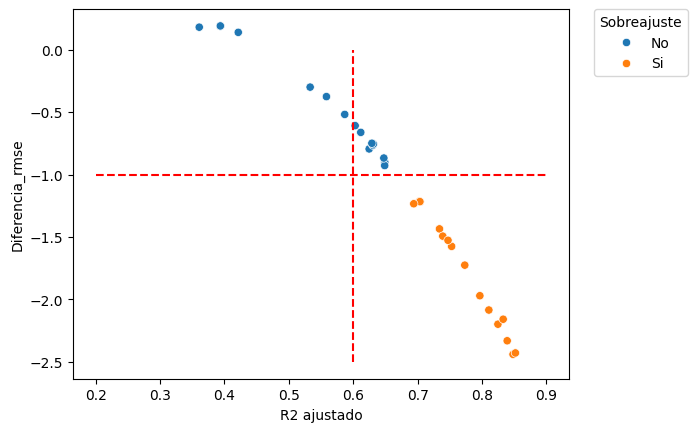

In [225]:
sns.scatterplot(data=df_metricas,x='R2 ajustado',y='Diferencia_rmse',hue='Sobreajuste')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Sobreajuste')
plt.hlines(y=-1,xmin=0.2,xmax=0.9,colors='r',linestyles='--')
plt.vlines(x=0.6,ymin=-2.5,ymax=0,colors='r',linestyles='--')
plt.show()

In [246]:
y_pred_RF_v2_4_2_3=modelo_RF_Reg_v2_4_2_3.predict(X_test_reg)
y_pred_ET_v2=modelo_ET_REG_v2.predict(X_test_reg)

#### funciones

###### grafico scatterplot comparacion real vs predicción

In [162]:
# @title
def graf_scatterplot(y,y_pred,modelo,conjunto):
  plt.figure(figsize=(8, 6))
  plt.scatter(y, y_pred, alpha=0.5)
  plt.title(f'Scatterplot entre Recuperación real y predicha con regresión {modelo} datos {conjunto}')
  plt.xlim(50, 100)
  plt.ylim(50, 100)
  plt.xlabel('Recuperación real')
  plt.ylabel(f'Recuperacion regresión {modelo} datos {conjunto}')
  
  plt.grid(True)
  plt.show()

### grafico comparación

#### Scatterplot entre Recuperación real - Random Forest

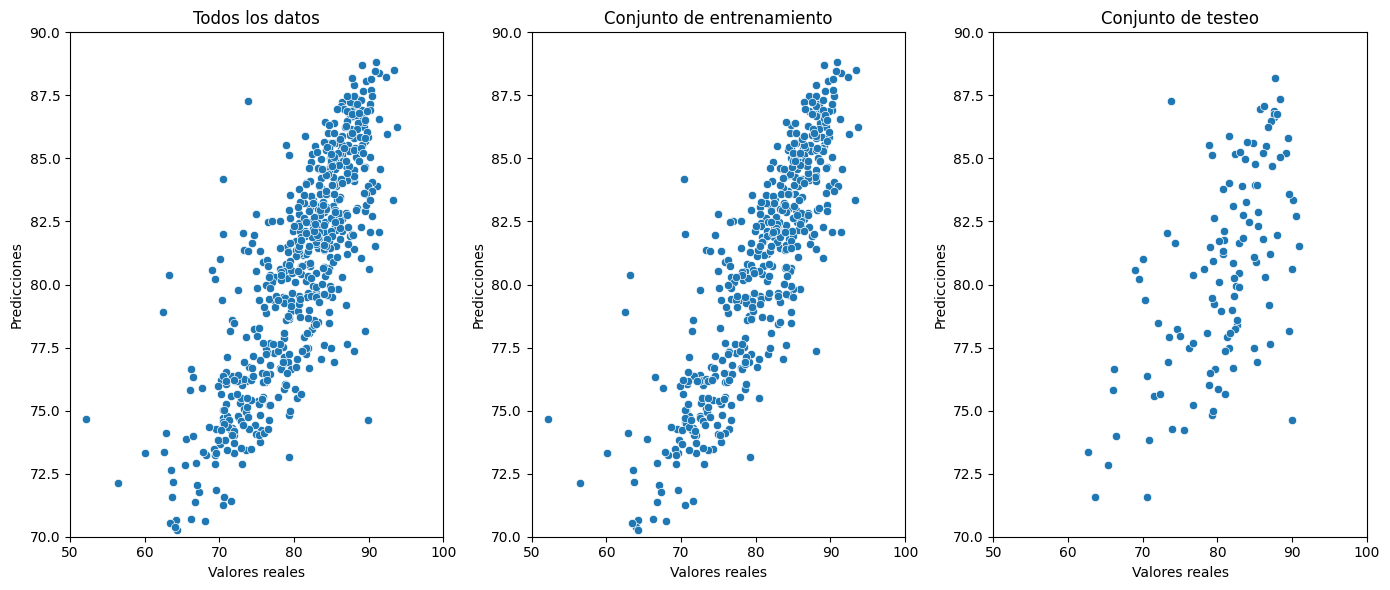

In [247]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

# Gráfico de dispersión para el conjunto de prueba
sns.scatterplot(x=y_reg, y=modelo_RF_Reg_v2_4_2_3.predict(X_reg.drop(columns='cumple')), ax=ax[0])
ax[0].set_title("Todos los datos")
ax[0].set_xlabel("Valores reales")
ax[0].set_ylabel("Predicciones")
ax[0].set_xlim(50, 100)
ax[0].set_ylim(70, 90)

# Gráfico de dispersión para el conjunto de entrenamiento
sns.scatterplot(x=y_train_reg, y=modelo_RF_Reg_v2_4_2_3.predict(X_train_reg), ax=ax[1])
ax[1].set_title("Conjunto de entrenamiento")
ax[1].set_xlabel("Valores reales")
ax[1].set_ylabel("Predicciones")
ax[1].set_xlim(50, 100)
ax[1].set_ylim(70, 90)

# Gráfico de dispersión para el conjunto de prueba
sns.scatterplot(x=y_test_reg, y=modelo_RF_Reg_v2_4_2_3.predict(X_test_reg), ax=ax[2])
ax[2].set_title("Conjunto de testeo")
ax[2].set_xlabel("Valores reales")
ax[2].set_ylabel("Predicciones")
ax[2].set_xlim(50, 100)
ax[2].set_ylim(70, 90)

plt.tight_layout()
plt.show()


#### Scatterplot entre Recuperación real - ExtraTrees

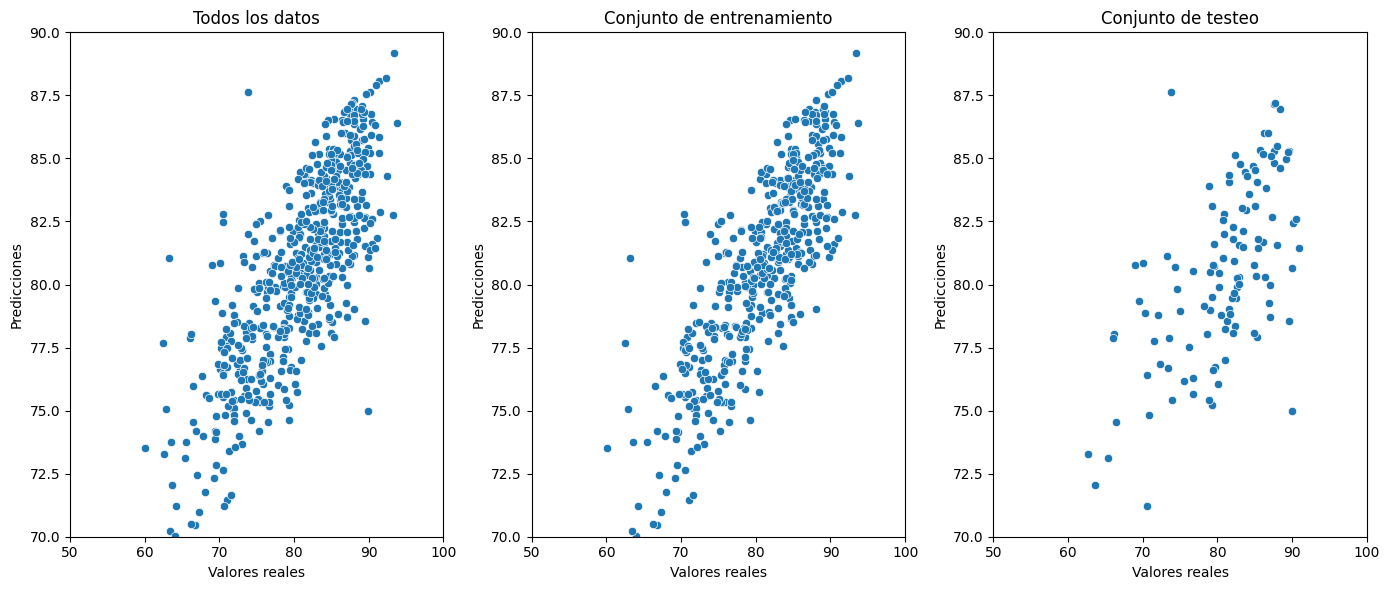

In [248]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

# Gráfico de dispersión para el conjunto de prueba
sns.scatterplot(x=y_reg, y=modelo_ET_REG_v2.predict(X_reg.drop(columns='cumple')), ax=ax[0])
ax[0].set_title("Todos los datos")
ax[0].set_xlabel("Valores reales")
ax[0].set_ylabel("Predicciones")
ax[0].set_xlim(50, 100)
ax[0].set_ylim(70, 90)

# Gráfico de dispersión para el conjunto de entrenamiento
sns.scatterplot(x=y_train_reg, y=modelo_ET_REG_v2.predict(X_train_reg), ax=ax[1])
ax[1].set_title("Conjunto de entrenamiento")
ax[1].set_xlabel("Valores reales")
ax[1].set_ylabel("Predicciones")
ax[1].set_xlim(50, 100)
ax[1].set_ylim(70, 90)

# Gráfico de dispersión para el conjunto de prueba
sns.scatterplot(x=y_test_reg, y=modelo_ET_REG_v2.predict(X_test_reg), ax=ax[2])
ax[2].set_title("Conjunto de testeo")
ax[2].set_xlabel("Valores reales")
ax[2].set_ylabel("Predicciones")
ax[2].set_xlim(50, 100)
ax[2].set_ylim(70, 90)

plt.tight_layout()
plt.show()

## salvar modelos seleccionados

###### salvar modelo

In [249]:
# Guarda el modelo
joblib.dump(modelo_RF_Reg_v2_4_2_3, 'Modelos/RandomForestReg.joblib')
joblib.dump(modelo_ET_REG_v2, 'Modelos/ExtraTreesReg.joblib')

['Modelos/ExtraTreesReg.joblib']